# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Sun Dec 31 14:11:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.1.0+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

- Make model more complex: Add more layers to the model
- Get More Quality Data: Alternatively, We could get our hands on some quality data to train our model on.
- Train for more Epochs: Maybe the model is not getting enough time to get itself familiarize with the data. So, increasing the number of epochs might help.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data

import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/ "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one......")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)


Did not find data/pizza_steak_sushi directory, creating one......
Unzipping pizza, steak, sushi data...


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
# Setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random Image Path: data/pizza_steak_sushi/train/sushi/3251688.jpg
Image class: sushi
Image height: 512
Image width: 512


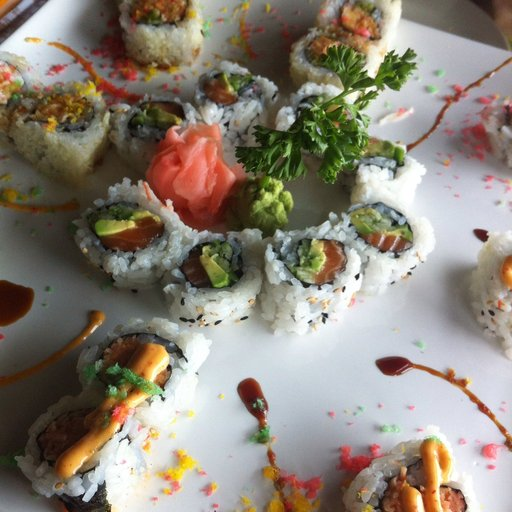

In [6]:
# Visualize an image

import random
from PIL import Image

RANDOM_SEED = 1

random.seed(RANDOM_SEED)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

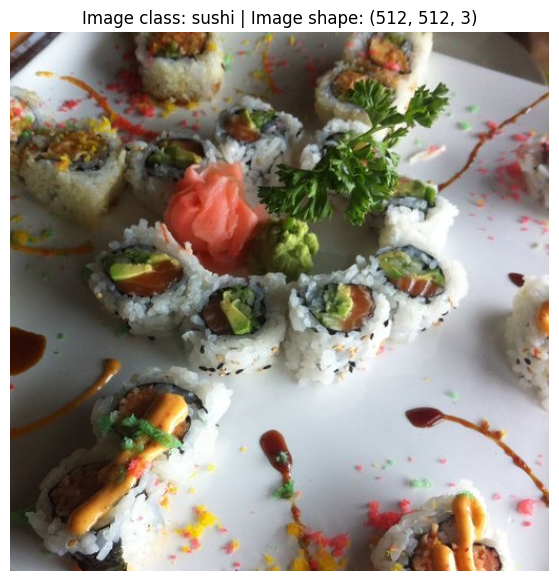

In [7]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis("off")

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [8]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [9]:
# Write transform for turning images into tensors
train_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

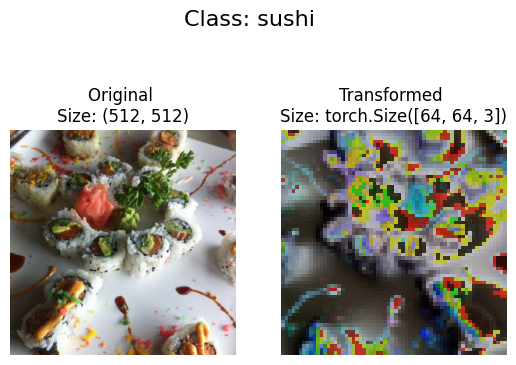

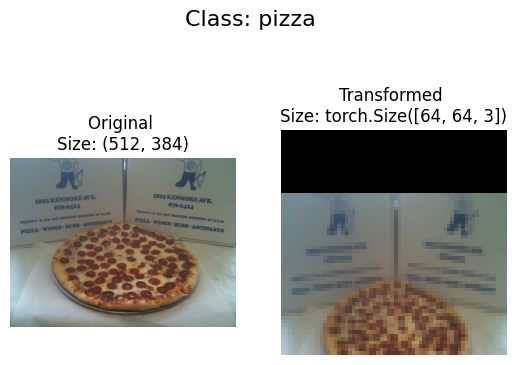

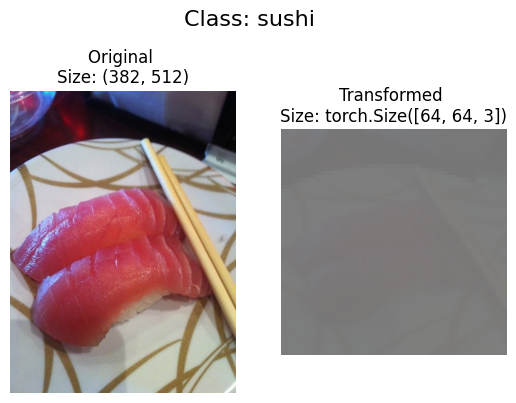

In [10]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=RANDOM_SEED):
  """
  Plots a series of random images from image_paths.

  Will open n image paths from image_paths, transform them with transform
  and plot them side by side

  Args:
    image_paths (list): List of target image paths
    transform (PyTorch Tranforms): Transforms to apply to images.
    n (int, optional): Number of images to plot. Defaults to 3.
    seed (int, optional): Random seed for the random generator. Defaults to 42.
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=train_data_transform)

### Load image data using `ImageFolder`

In [11]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_data_transform,
    target_transform=None
)
test_data = datasets.ImageFolder(
    root=test_dir,
    transform=test_data_transform
)

In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

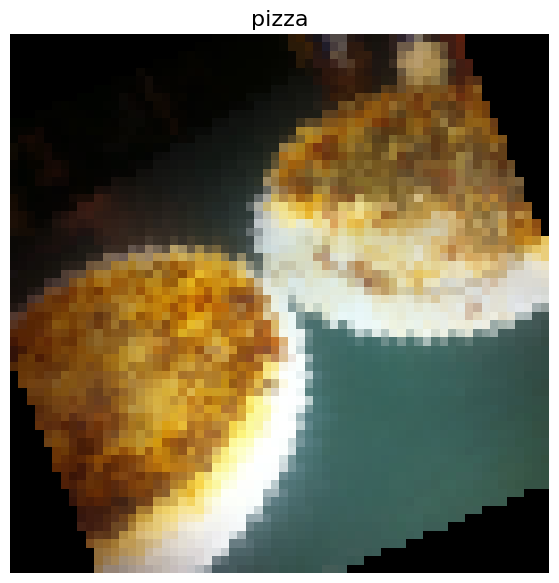

In [15]:
img, label = train_data[0][0], train_data[0][1]
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=16)

In [16]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False
)

In [17]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [18]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
      )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*16*16,
            out_features=output_shape
        )
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data.classes)
).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [19]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_logits = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_logits, y)
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    train_acc += ((y_pred == y).sum().item()/len(y_pred))

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [20]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):

      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      y_test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
      test_acc += (y_test_pred == y).sum().item()/len(y_test_pred)

  # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
  return test_loss, test_acc

In [21]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [22]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [23]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1080 | train_acc: 0.2422 | test_loss: 1.1071 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0787 | train_acc: 0.4258 | test_loss: 1.1403 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0817 | train_acc: 0.4258 | test_loss: 1.1709 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1289 | train_acc: 0.3047 | test_loss: 1.1614 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0916 | train_acc: 0.4258 | test_loss: 1.1474 | test_acc: 0.2604


{'train_loss': [tensor(1.1080, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0787, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0817, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1289, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0916, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [0.2421875, 0.42578125, 0.42578125, 0.3046875, 0.42578125],
 'test_loss': [1.1070567766825359,
  1.1402583122253418,
  1.1708738605181377,
  1.1613656282424927,
  1.1474310159683228],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667]}

In [24]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1018 | train_acc: 0.2773 | test_loss: 1.1060 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0883 | train_acc: 0.4258 | test_loss: 1.1129 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0816 | train_acc: 0.4258 | test_loss: 1.1353 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1190 | train_acc: 0.3047 | test_loss: 1.1488 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0877 | train_acc: 0.4258 | test_loss: 1.1460 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1010 | train_acc: 0.3047 | test_loss: 1.1466 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.0952 | train_acc: 0.3047 | test_loss: 1.1442 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.0972 | train_acc: 0.2734 | test_loss: 1.1458 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1180 | train_acc: 0.2969 | test_loss: 1.1447 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.0946 | train_acc: 0.3320 | test_loss: 1.1211 | test_acc: 0.2812
Epoch: 11 | train_loss: 1.0767 | train_acc: 0.4141 | test_loss: 1.1237 | test_acc: 0.2604
Epoch: 12 | train_l

{'train_loss': [tensor(1.1018, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0883, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0816, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1190, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0877, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1010, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0952, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0972, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1180, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0946, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0767, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1092, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0909, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0898, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0809, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0803, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0707, device='cuda:0', grad_fn=

In [25]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=50
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0160 | train_acc: 0.4258 | test_loss: 1.1363 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0829 | train_acc: 0.4258 | test_loss: 1.1335 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0737 | train_acc: 0.4258 | test_loss: 1.1140 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1057 | train_acc: 0.3086 | test_loss: 1.1123 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0618 | train_acc: 0.4180 | test_loss: 1.1239 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0585 | train_acc: 0.3203 | test_loss: 1.1352 | test_acc: 0.2708
Epoch: 7 | train_loss: 1.0582 | train_acc: 0.3984 | test_loss: 1.1296 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0473 | train_acc: 0.5547 | test_loss: 1.1255 | test_acc: 0.3229
Epoch: 9 | train_loss: 1.0485 | train_acc: 0.4492 | test_loss: 1.1144 | test_acc: 0.3731
Epoch: 10 | train_loss: 1.0353 | train_acc: 0.4531 | test_loss: 1.0171 | test_acc: 0.4015
Epoch: 11 | train_loss: 0.9326 | train_acc: 0.5273 | test_loss: 1.0348 | test_acc: 0.4034
Epoch: 12 | train_l

{'train_loss': [tensor(1.0160, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0829, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0737, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1057, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0618, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0585, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0582, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0473, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0485, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0353, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9326, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9594, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0548, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9314, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9685, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9302, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8817, device='cuda:0', grad_fn=

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [26]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(
    input_shape=3,
    hidden_units=20,
    output_shape=len(train_data.classes)
).to(device)
model_0

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_1.parameters(), lr=0.1)

train(
    model=model_1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4515.5625 | train_acc: 0.3203 | test_loss: 1.2706 | test_acc: 0.2083
Epoch: 2 | train_loss: 1.2022 | train_acc: 0.2930 | test_loss: 1.1067 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1136 | train_acc: 0.3047 | test_loss: 1.1309 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1011 | train_acc: 0.2734 | test_loss: 1.0926 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1088 | train_acc: 0.2969 | test_loss: 1.1041 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0962 | train_acc: 0.3008 | test_loss: 1.1431 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.0866 | train_acc: 0.4180 | test_loss: 1.1712 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.1156 | train_acc: 0.3047 | test_loss: 1.1727 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1265 | train_acc: 0.3047 | test_loss: 1.1375 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.0980 | train_acc: 0.3164 | test_loss: 1.0827 | test_acc: 0.5417
Epoch: 11 | train_loss: 1.1354 | train_acc: 0.2617 | test_loss: 1.1093 | test_acc: 0.1979
Epoch: 12 | trai

{'train_loss': [tensor(4515.5625, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.2022, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1136, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1011, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1088, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0962, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0866, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1156, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1265, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0980, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1354, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1145, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0876, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1102, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1293, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0926, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1336, device='cuda:0', grad_

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [27]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [28]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.


Excellent, we now have double the training and testing images...

In [29]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [30]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data = datasets.ImageFolder(
    root=train_data_20_percent_path,
    transform=simple_transform,
    target_transform=None
)
test_data = datasets.ImageFolder(
    root=test_data_20_percent_path,
    transform=simple_transform,
)


# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True,
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False
)

In [31]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=50

)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8391 | train_acc: 0.6458 | test_loss: 0.8767 | test_acc: 0.5852
Epoch: 2 | train_loss: 0.8503 | train_acc: 0.6167 | test_loss: 0.8871 | test_acc: 0.6006
Epoch: 3 | train_loss: 0.8302 | train_acc: 0.5896 | test_loss: 0.8768 | test_acc: 0.5847
Epoch: 4 | train_loss: 0.7397 | train_acc: 0.6708 | test_loss: 0.8953 | test_acc: 0.6415
Epoch: 5 | train_loss: 0.7553 | train_acc: 0.6833 | test_loss: 0.8966 | test_acc: 0.5972
Epoch: 6 | train_loss: 0.7579 | train_acc: 0.6562 | test_loss: 0.8728 | test_acc: 0.6318
Epoch: 7 | train_loss: 0.7423 | train_acc: 0.7000 | test_loss: 0.8816 | test_acc: 0.6381
Epoch: 8 | train_loss: 0.7059 | train_acc: 0.6917 | test_loss: 0.8667 | test_acc: 0.6347
Epoch: 9 | train_loss: 0.7028 | train_acc: 0.6854 | test_loss: 0.8896 | test_acc: 0.6068
Epoch: 10 | train_loss: 0.6897 | train_acc: 0.7125 | test_loss: 0.8702 | test_acc: 0.6193
Epoch: 11 | train_loss: 0.6736 | train_acc: 0.7271 | test_loss: 0.9151 | test_acc: 0.6136
Epoch: 12 | train_l

{'train_loss': [tensor(0.8391, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8503, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8302, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7397, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7553, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7579, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7423, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7059, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7028, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6897, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6736, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6829, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6808, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6399, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6148, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6215, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.5883, device='cuda:0', grad_fn=

In [33]:
from typing import List
import torchvision

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [39]:
import requests
def get_images(urls):
  custom_image_paths = []
  for i, url in enumerate(urls):
    custom_image_path = data_path / f"test-image-{i}.jpg"


    if not custom_image_path.is_file():
      with open(custom_image_path, "wb") as f:
        request = requests.get(url)
        print(f"Downloading {custom_image_path}")
        custom_image_paths.append(custom_image_path)
        f.write(request.content)
    else:
      print(f"{custom_image_path} already exists")

  return custom_image_paths

In [40]:
urls=[
    "https://img.freepik.com/free-photo/top-view-pepperoni-pizza-with-mushroom-sausages-bell-pepper-olive-corn-black-wooden_141793-2158.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Pizza-3007395.jpg/220px-Pizza-3007395.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRDk7sJqHe4Wt30q9D8XniRT5TPYs-MlJ4yhncbTd2u3A&s",
    "https://img.freepik.com/free-photo/juicy-steak-medium-rare-beef-with-spices-grilled-vegetables_24972-2328.jpg?size=626&ext=jpg&ga=GA1.1.1546980028.1703980800&semt=sph"
]

custom_image_paths = get_images(urls)

data/test-image-0.jpg already exists


In [41]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_paths[0]))

print(f"Custom image tensor: \n{custom_image_uint8}\n")
print(f"Custom image shape: \n{custom_image_uint8.shape}\n")
print(f"Custom image dtype: \n{custom_image_uint8.dtype}")


Custom image tensor: 
tensor([[[  3,   2,   0,  ...,  92,  47,  60],
         [  4,   4,   1,  ...,  74,  28,  49],
         [  8,   7,   5,  ...,  40,   6,  28],
         ...,
         [  3,   3,   0,  ...,   9,   9,   8],
         [  1,   3,   0,  ...,   9,   9,   8],
         [  0,   4,   2,  ...,   8,   8,   8]],

        [[  0,   1,   3,  ..., 111,  64,  78],
         [  0,   0,   1,  ...,  93,  46,  67],
         [  0,   0,   0,  ...,  57,  22,  45],
         ...,
         [  3,   4,   1,  ...,  10,  10,   9],
         [  0,   3,   1,  ...,  10,  10,   9],
         [  0,   4,   3,  ...,   9,   9,   9]],

        [[  0,   0,   0,  ..., 126,  80,  92],
         [  0,   0,   1,  ..., 108,  60,  79],
         [  3,   5,   6,  ...,  73,  35,  55],
         ...,
         [  1,   0,   0,  ...,  12,  12,  11],
         [  2,   1,   0,  ...,  12,  12,  11],
         [  4,   4,   0,  ...,  11,  11,  11]]], dtype=torch.uint8)

Custom image shape: 
torch.Size([3, 147, 220])

Custom image dty

In [42]:
custom_images = []

for image_path in custom_image_paths:
  custom_image_uint8 = torchvision.io.read_image(str(image_path))
  custom_image = custom_image_uint8 / 255
  custom_images.append(custom_image)
custom_images

[tensor([[[0.0118, 0.0078, 0.0000,  ..., 0.3608, 0.1843, 0.2353],
          [0.0157, 0.0157, 0.0039,  ..., 0.2902, 0.1098, 0.1922],
          [0.0314, 0.0275, 0.0196,  ..., 0.1569, 0.0235, 0.1098],
          ...,
          [0.0118, 0.0118, 0.0000,  ..., 0.0353, 0.0353, 0.0314],
          [0.0039, 0.0118, 0.0000,  ..., 0.0353, 0.0353, 0.0314],
          [0.0000, 0.0157, 0.0078,  ..., 0.0314, 0.0314, 0.0314]],
 
         [[0.0000, 0.0039, 0.0118,  ..., 0.4353, 0.2510, 0.3059],
          [0.0000, 0.0000, 0.0039,  ..., 0.3647, 0.1804, 0.2627],
          [0.0000, 0.0000, 0.0000,  ..., 0.2235, 0.0863, 0.1765],
          ...,
          [0.0118, 0.0157, 0.0039,  ..., 0.0392, 0.0392, 0.0353],
          [0.0000, 0.0118, 0.0039,  ..., 0.0392, 0.0392, 0.0353],
          [0.0000, 0.0157, 0.0118,  ..., 0.0353, 0.0353, 0.0353]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.4941, 0.3137, 0.3608],
          [0.0000, 0.0000, 0.0039,  ..., 0.4235, 0.2353, 0.3098],
          [0.0118, 0.0196, 0.0235,  ...,

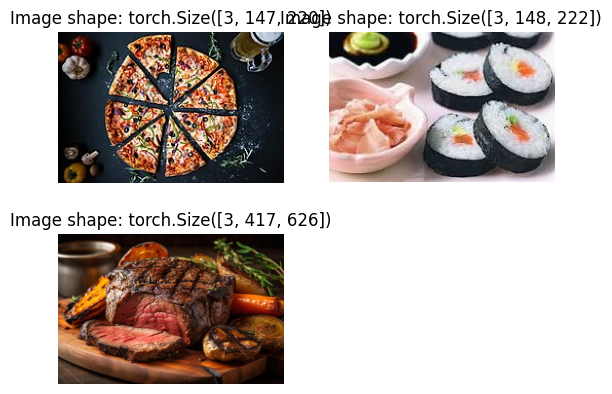

In [47]:
for i, image in enumerate(custom_images):
  plt.subplot(2, 2, i+1)
  plt.imshow(image.permute(1, 2, 0))
  plt.title(f"Image shape: {image.shape}")
  plt.axis("off")

In [57]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

custom_images_transformed = []
for image in custom_images:
  print(f"Original shape: {image.shape}")
  image = custom_image_transform(image)
  print(f"New shape: {image.shape}")
  custom_images_transformed.append(image)

Original shape: torch.Size([3, 147, 220])
New shape: torch.Size([3, 64, 64])
Original shape: torch.Size([3, 148, 222])
New shape: torch.Size([3, 64, 64])
Original shape: torch.Size([3, 417, 626])
New shape: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [58]:
model_0.eval()
with torch.inference_mode():
  labels = []
  for image in custom_images_transformed:
    print(f"Custom image transformed shape: {image.shape}")

    image = image.unsqueeze(dim=0)
    image = image.to(device)
    print(f"Unsqueezed custom image: {image.shape}")

    label = model_0(image).to(device)
    labels.append(label)

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image: torch.Size([1, 3, 64, 64])
Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image: torch.Size([1, 3, 64, 64])
Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image: torch.Size([1, 3, 64, 64])


In [60]:
for i, label in enumerate(labels):
  print(f"Prediction Logits: {labels[i]}")

  custom_image_pred_probs = torch.softmax(label, dim=1)
  print(f"Prediction probabilities: {custom_image_pred_probs}")

  custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
  print(f"Prediction Label: {custom_image_pred_label}")

  custom_image_pred_class = class_names[custom_image_pred_label]
  print(custom_image_pred_class)

Prediction Logits: tensor([[ -4.0074, -16.6832, -11.5043]], device='cuda:0')
Prediction probabilities: tensor([[9.9944e-01, 3.1241e-06, 5.5452e-04]], device='cuda:0')
Prediction Label: tensor([0], device='cuda:0')
pizza
Prediction Logits: tensor([[-18.3009, -16.5778,  -6.9619]], device='cuda:0')
Prediction probabilities: tensor([[1.1898e-05, 6.6650e-05, 9.9992e-01]], device='cuda:0')
Prediction Label: tensor([2], device='cuda:0')
sushi
Prediction Logits: tensor([[-5.6581, -0.8585, -7.5993]], device='cuda:0')
Prediction probabilities: tensor([[0.0082, 0.9907, 0.0012]], device='cuda:0')
Prediction Label: tensor([1], device='cuda:0')
steak


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


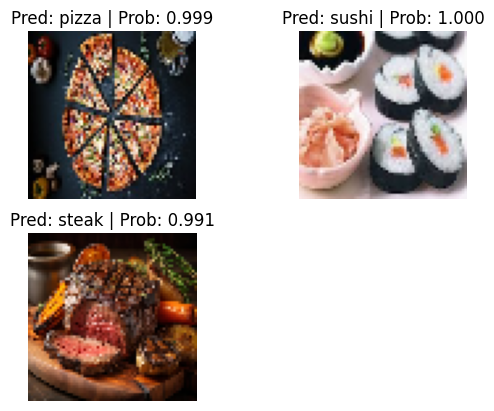

In [63]:
for i, image_path in enumerate(custom_image_paths):
  plt.subplot(2, 2, i+1)
  pred_and_plot_image(
      model=model_0,
      image_path=image_path,
      class_names=class_names,
      transform=custom_image_transform,
      device=device
  )